## Loading Libraries used for analysis

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import word_tokenize
from nltk import sent_tokenize
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
import pandas as pd
from collections import Counter
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Mounted at /content/gdrive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 2.9 MB/s eta 0:00:00


## Data loading

In [ ]:
ham_folder = "/content/gdrive/MyDrive/Colab Notebooks/664-Final/EmailSpamCorpora/corpus/ham"
spam_folder = "/content/gdrive/MyDrive/Colab Notebooks/664-Final/EmailSpamCorpora/corpus/spam"

# function to read in all text files in a folder
def read_text_files(folder_path):
    file_contents = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='iso-8859-1') as file:
            file_contents.append(file.read())
    return file_contents

# read in all ham emails
ham_emails = read_text_files(ham_folder)

# read in all spam emails
spam_emails = read_text_files(spam_folder)

In [ ]:
# create tuples based off emails
# ham = 0 and spam = 1 in the `label` column
ham_tup = [(email, 0) for email in ham_emails]
spam_tup = [(email, 1) for email in spam_emails]

# joining ham and spam
email_tup = ham_tup + spam_tup

# shuffle the email tuples
random.shuffle(email_tup)

# dataframe creation
email_df = pd.DataFrame(email_tup, columns=['email', 'label'])

# removing "Subject: " from the dataframe
def elim_subject(df):
    df['email'] = df['email'].str.replace(r'^Subject:\s+', '', regex=True)
    return df

email_df = elim_subject(email_df)

In [ ]:
# cleaning and processing dataframe
email_df['length'] = email_df['email'].apply(len)
email_df.sort_values(by='length', ascending=False)

email_df['email'] = email_df['email'].str.lower()

In [ ]:
# testing dataframe
email_df.head(10)

,email,label,length
0,shell houston open\nfirst come first serve :\n...,0,413
1,"f . o . m . hpl nom . eff . april 1 , 2001\nda...",0,1109
2,customer reciept # 4359 bn winkle\nsimply vist...,1,1038
3,affordable lev ! itra & v ( iagra ! overnight ...,1,57
4,"enron / hpl actuals for july 20 , 2000\nteco t...",0,118
5,"txu may 01\nmike ,\ni have the following outst...",0,189
6,wacog for sale to cannon winter 2000 - 01\nacc...,0,266
7,fw : hungry 30 to 40 girls wants to date you\n...,1,75
8,offshore pharmacy\nonline pharmacy provides se...,1,411
9,hello\nhow old can you really be to have fun ?...,1,206


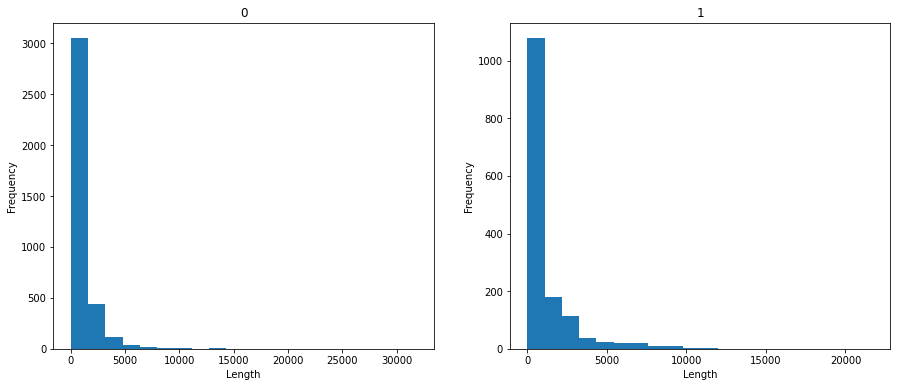

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for ax, label in zip(axes.flatten(), [0, 1]):
    email_df[email_df['label']==label]['length'].plot.hist(ax=ax, bins=20)
    ax.set_xlabel('Length')
    ax.set_ylabel('Frequency')
    ax.set_title(label)
    
plt.show()

## Preprocessing/Cleaning

In [ ]:
# setting stopwords language
stop_words = stopwords.words('english')
','.join(stop_words)

# function to remove stopwords
def elim_stop(stop_value):
  return " " .join([word for word in str(stop_value).split() if word not in stop_words])

email_df['email']=email_df['email'].apply(lambda stop_value: elim_stop(stop_value))

email_df.head()

,email,label,length
0,shell houston open first come first serve : : ...,0,413
1,"f . . . hpl nom . eff . april 1 , 2001 daren ,...",0,1109
2,customer reciept # 4359 bn winkle simply visti...,1,1038
3,affordable lev ! itra & v ( iagra ! overnight ...,1,57
4,"enron / hpl actuals july 20 , 2000 teco tap 10...",0,118


In [ ]:
# defining punctuation
punctuation_values = string.punctuation

# remove punctuation from `email_df`
def elim_punc(punc):
  return punc.translate(str.maketrans('','',punctuation_values))

email_df['email']=email_df['email'].apply(lambda punc: elim_punc(punc))

### Visualizations

In [ ]:
# generating subsets of `email_df`
ham_df = email_df[email_df['label'] == 0]
spam_df = email_df[email_df['label'] == 1]

# generating text for WordCloud usage
ham_text = ' '.join(ham_df['email'].tolist())
spam_text = ' '.join(spam_df['email'].tolist())

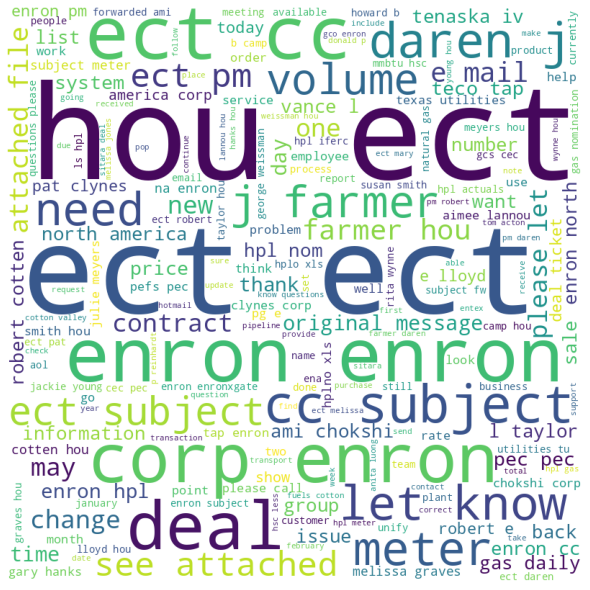

In [ ]:
# Ham WordCloud
ham_wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(ham_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

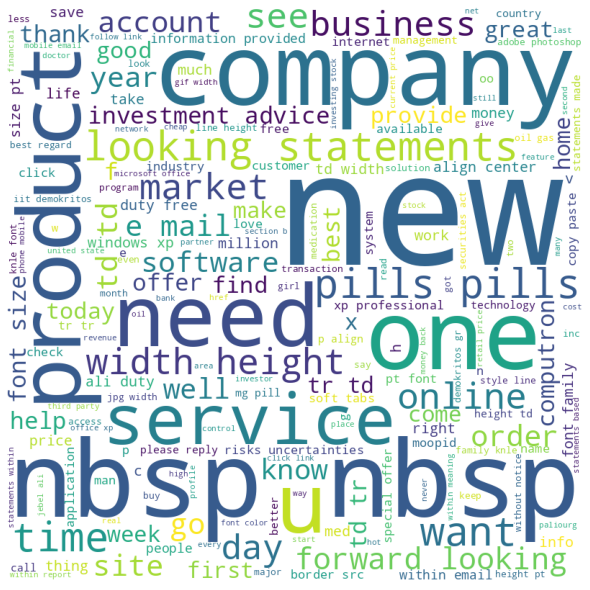

In [ ]:
# Spam WordCloud
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(spam_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Analysis

### Naive Bayes

In [ ]:
# Bag of Words feature matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(email_df['email'])
y = email_df['label']

In [ ]:
# splitting data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [ ]:
# Naives Bayes model training
nb_email = MultinomialNB()
nb_email.fit(X_train, y_train)

# predictions based on test data
y_pred = nb_email.predict(X_test)

In [ ]:
# checking model accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy: ', accuracy)

Model Accuracy:  0.9813144329896907


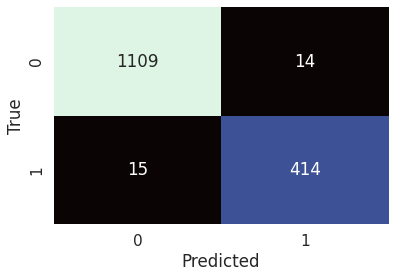

In [ ]:
# confusion matrix creation
cm_email = confusion_matrix(y_test, y_pred)

# plotting confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm_email, annot=True, fmt='g', cmap='mako', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
cv_scores = cross_val_score(nb_email, X, y, cv=5)
print('Cross-validation scores:', cv_scores)

recall = recall_score(y_test, y_pred)
print('Recall score:', recall)

f1 = f1_score(y_test, y_pred)
print('F-measure score:', f1)

Cross-validation scores: [0.97487923 0.96618357 0.98549323 0.98065764 0.98355899]
Recall score: 0.965034965034965
F-measure score: 0.9661610268378064


* 1504/1552 correctly identified spam emails



### Gaussian Naive Bayes + VADER Implementation

In [ ]:
# using VADER
analyzer = SentimentIntensityAnalyzer()

# adding sentiment values
email_df['sentiment'] = email_df['email'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
email_df.head(10)

,email,label,length,sentiment
0,shell houston open first come first serve 10...,0,413,0.9493
1,f hpl nom eff april 1 2001 daren tried ...,0,1109,0.7717
2,customer reciept 4359 bn winkle simply visti ...,1,1038,0.9661
3,affordable lev itra v iagra overnight deli...,1,57,0.0000
4,enron hpl actuals july 20 2000 teco tap 10 ...,0,118,0.0000
5,txu may 01 mike following outstanding issue t...,0,189,0.7845
6,wacog sale cannon winter 2000 01 according co...,0,266,0.0000
7,fw hungry 30 40 girls wants date hello pama ...,1,75,0.0000
8,offshore pharmacy online pharmacy provides sec...,1,411,-0.7506
9,hello old really fun right area lonely hoys...,1,206,0.2716


In [ ]:
# variables
X = email_df[['email', 'sentiment']]
y = email_df['label']

In [ ]:
# extract word features
vectorizer = CountVectorizer()
X_vect = vectorizer.fit_transform(X["email"])

In [ ]:
# add VADER sentiment to train data
X_vader = np.hstack((X_vect.toarray(), X[["sentiment"]].values))

In [ ]:
# splitting data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vader, y, test_size=0.3, random_state=17)

In [ ]:
# Naives Bayes + VADER model training
nb_vader = GaussianNB()
nb_vader.fit(X_train, y_train)

GaussianNB()

In [ ]:
# label prediction
y_pred = nb_vader.predict(X_test)

In [ ]:
# checking model accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy: ', accuracy)

Model Accuracy:  0.9594072164948454


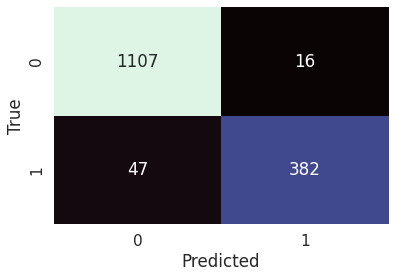

In [ ]:
# confusion matrix creation
cm_email = confusion_matrix(y_test, y_pred)

# plotting confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm_email, annot=True, fmt='g', cmap='mako', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
cv_scores = cross_val_score(nb_vader, X_vader, y, cv=5)
print('Cross-validation scores:', cv_scores)

recall = recall_score(y_test, y_pred)
print('Recall score:', recall)

f1 = f1_score(y_test, y_pred)
print('F-measure score:', f1)

Cross-validation scores: [0.95652174 0.94879227 0.96808511 0.96131528 0.96131528]
Recall score: 0.8904428904428905
F-measure score: 0.9238210399032649


### Gaussian Naive Bayes + VADER Implementation using TF-IDF scores

In [ ]:
# variables
X = email_df['email']
y = email_df['label']

In [ ]:
# extract word features
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(X)

In [ ]:
# add VADER sentiment to train data
X_vader = np.hstack((X_vect.toarray(), email_df[["sentiment"]].values))

In [ ]:
# splitting data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vader, y, test_size=0.3, random_state=17)

In [ ]:
# Naives Bayes + VADER model training
nb_tfidf = GaussianNB()
nb_tfidf.fit(X_train, y_train)

GaussianNB()

In [ ]:
# label prediction
y_pred = nb_tfidf.predict(X_test)

In [ ]:
# checking model accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy: ', accuracy)

Model Accuracy:  0.9542525773195877


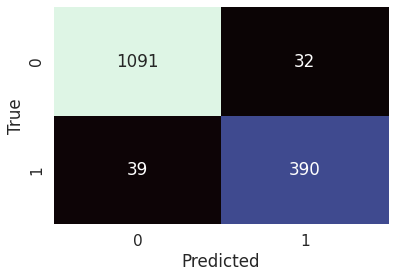

In [ ]:
# confusion matrix creation
cm_email = confusion_matrix(y_test, y_pred)

# plotting confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm_email, annot=True, fmt='g', cmap='mako', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
cv_scores = cross_val_score(nb_tfidf, X_vader, y, cv=5)
print('Cross-validation scores:', cv_scores)

recall = recall_score(y_test, y_pred)
print('Recall score:', recall)

f1 = f1_score(y_test, y_pred)
print('F-measure score:', f1)

Cross-validation scores: [0.95072464 0.94009662 0.96711799 0.95551257 0.95261122]
Recall score: 0.9090909090909091
F-measure score: 0.9165687426556992
